# Classify MNIST

In [1]:
# for leonhard
import os

%load_ext autoreload
# Train a Bayesian neural network to classify MNIST using
# (parallel) Langevin dynamics
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
import sys
on_cluster = not os.getenv("HOME") == "/home/lauro"
if on_cluster:
    sys.path.append("/cluster/home/dlauro/projects-2020-Neural-SVGD/")
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=" + os.environ["CUDA_HOME"]
    os.environ['XLA_FLAGS']

import argparse
import matplotlib.pyplot as plt
import numpy as onp
import jax.numpy as jnp
import jax

from jax import jit, value_and_grad, vmap, random, grad
from tqdm import tqdm
import optax

from nvgd.src import utils, metrics
from nvgd.experiments import dataloader, bnn
from nvgd.experiments import config as cfg

data = dataloader.data
on_cluster = not os.getenv("HOME") == "/home/lauro"

# Config
key = random.PRNGKey(0)
EPOCHS = 1
BATCH_SIZE = 128
LEARNING_RATE = 2e-7  # 1e-6 too high!!
NUM_SAMPLES = 100
DISABLE_PROGRESS_BAR = False



# initialize set of parameters
key, subkey = random.split(key)
param_set = vmap(bnn.model.init, (0, None))(
    random.split(subkey, NUM_SAMPLES), data.train_images[:5])

Loading data...


# Classic (non-Bayesian) training
* Train a classifier using SGD. 
* To be consistent with the BNN approach, all parameters (including biases) are initialized as $N(0, 1/100^2)$ (ie the prior).
* The training loss is $L^2$-regularized, corresponding roughly to the maximum a posteriori estimator with the normal prior.

Note: works fine with networks as small as 2-layer conv with 4 channels per layer (loss decreases steadily and accuracy is ~0.92 after two epochs).

In [2]:
adam_learning_rate = 1e-3
sgd_learning_rate = 2e-7
# opt = optax.sgd(sgd_learning_rate)
opt = optax.adam(adam_learning_rate)
# opt = utils.sgld(learning_rate)

@jit
def classic_step(params, opt_state, images, labels):
    step_loss, g = value_and_grad(bnn.loss)(params, images, labels)
    g, opt_state = opt.update(g, opt_state, params)
    return optax.apply_updates(params, g), opt_state, step_loss

@jit
def compute_accuracy(params):
    return bnn.val_accuracy_single_net(params)


key, subkey = random.split(key)
params = bnn.model.init(subkey, data.train_images[:2])
opt_state = opt.init(params)

ls = []
ces = []
accs = []
trajectory = []
step_count = 0

pflat = jax.flatten_util.ravel_pytree(params)[0]
pflat.shape

(4242,)

In [3]:
stds = []

In [4]:
for _ in tqdm(range(2000)):
    step_count += 1
    images, labels = next(data.train_batches)
    params, opt_state, step_loss = classic_step(params, opt_state, images, labels)

    ls.append(step_loss)

    if step_count % 100 == 0:
        trajectory.append(jax.flatten_util.ravel_pytree(params)[0])
        current_acc = compute_accuracy(params)
        accs.append((step_count, current_acc))

100%|██████████| 2000/2000 [00:55<00:00, 36.11it/s]


final accuracy: 0.97401494


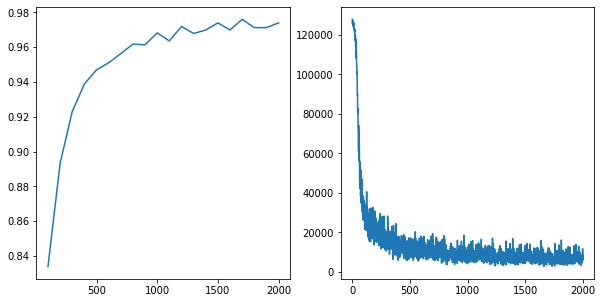

In [5]:
# 4.5k params
print("final accuracy:", accs[-1][-1])
fig, axs = plt.subplots(1, 2, figsize=[10, 5])
axs[0].plot(*zip(*accs))
axs[1].plot(ls)

In [6]:
# plt.plot([jnp.std(p) for p in trajectory])

In [7]:
pflat_trained = jax.flatten_util.ravel_pytree(params)[0]

In [8]:
print(jnp.mean(pflat))
print(jnp.std(pflat))

-0.0025130133
0.15105644


In [9]:
print(jnp.mean(pflat_trained))
print(jnp.std(pflat_trained))

0.005561628
0.15479042


In [10]:
trajectory_arr = onp.array(trajectory)

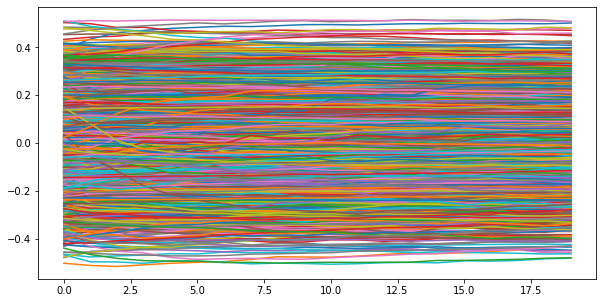

In [11]:
# visualize trajectory of each parameter
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(trajectory_arr);